In [1]:
######
# Create train/validation/test splits
# This script will split the data/data.tsv into train/validation/test.tsv files
######

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


data = pd.read_csv('data/data.tsv',sep="\t") #load into DataFrame type 

x_tot = data["text"]
y_tot = data ["label"]

#Splitting data into train (0.64), test (0.2), validation (0.16)
x, x_test, y, y_test = train_test_split(x_tot,y_tot,test_size=0.2,train_size=0.8, random_state = 0, stratify = y_tot) # 0.8 = train + validation)
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.2, random_state = 0, stratify = y) #0.2 x 0.8 = 0.16 validation

print("Total examples in test", x_test.shape)
print("Total examples in train", x_train.shape)
print("Total examples in validation", x_val.shape)

test = y_test.value_counts()
train = y_train.value_counts()
val = y_val.value_counts()

print("\nTEST: Ex. in each class\n", test)
print("\nTRAIN: Ex. in each class\n", train)
print("\nVALIDATION: Ex. in each class\n", val)

#Concatenate text and labels & load into tsv files 
testdata = pd.concat([x_test, y_test],axis = 1)
testdata.to_csv("data/test.tsv", sep="\t",index=False)

traindata = pd.concat([x_train, y_train],axis = 1)
traindata.to_csv("data/train.tsv", sep="\t",index=False)

valdata = pd.concat([x_val, y_val],axis = 1)
valdata.to_csv("data/validation.tsv", sep="\t",index=False)

#Create 4th dataset (overfit) for debugging (randomly taken from traindata)
overfit = traindata.groupby('label', group_keys=False).apply(lambda x: x.sample(25))
overfit.to_csv("data/overfit.tsv", sep="\t",index=False)



Total examples in test (2000,)
Total examples in train (6400,)
Total examples in validation (1600,)

TEST: Ex. in each class
 1    1000
0    1000
Name: label, dtype: int64

TRAIN: Ex. in each class
 1    3200
0    3200
Name: label, dtype: int64

VALIDATION: Ex. in each class
 1    800
0    800
Name: label, dtype: int64


In [2]:
# Note: This ipynb contains the MAIN codes for training on the FULL dataset for all 3 MODELS

# The overfit code used to obtain the overfit graphs is in: 
# baseline_overfit.ipynb, cnn_overfit.ipynb, rnn_overfit.ipynb

In [3]:
import torch
import torch.optim as optim

import torchtext
from torchtext import data
import spacy

import argparse
import os


from models import * #in separate models.py file

import torch.nn as nn
from torch.autograd import Variable
import time

import matplotlib.pyplot as plt

# Hyperparameters 
learning_rate = 0.001
batch_size = 64
epochs = 25 
seed = 0

torch.manual_seed(seed)

In [4]:
# Accuracy function (used for all 3 models)
def accuracy(predictions, labels):
    totalCor = 0
    ind = 0
    
    for c in predictions:
        if (c.item()>0.5):
            r = 1.0
        else:
            r = 0.0
        
        if (r== labels[ind].item()):
            totalCor += 1
        ind += 1
    
    return (totalCor/len(labels))

In [5]:
# Evaluate function (used for baseline,CNN)
def evaluate(model, val_iter):
    loss_fnc = nn.BCEWithLogitsLoss()

    correct = 0 
    total = 0 
    
    batchloss_accum = 0.0
    batchacc_accum = 0.0
    
    for i,batch in enumerate(val_iter,0): #go through each batch in val_loader
        
        batch_input, batch_input_length = batch.text
        sentence_length = batch_input_length[0].item() # = len(batch_input)
        
        outputs = model(torch.reshape(batch_input,(sentence_length,len(batch)))) #batch has size [sentence length, batch size]
        
        #Calculate accuracy 
        acc = accuracy(outputs,batch.label.float())
        batchacc_accum = batchacc_accum + acc
        
        #Calculate loss
        batchloss = loss_fnc(outputs, batch.label.float()) #batch.label --> tensor of 64 1s and 0s
        batchloss_accum = batchloss_accum + batchloss.item()


    avgbatchloss = batchloss_accum/len(val_iter)
    avgbatchacc = batchacc_accum/len(val_iter)
    
    return avgbatchacc, avgbatchloss

Shape of Vocab: torch.Size([21105, 100])
avg acc/epoch 0.5
[1,   100] avg loss/epoch: 0.676
validation loss: 0.647315571308136
validation acc: 0.5
avg acc/epoch 0.5146875
[2,   100] avg loss/epoch: 0.623
validation loss: 0.5988921475410461
validation acc: 0.54125
avg acc/epoch 0.56296875
[3,   100] avg loss/epoch: 0.579
validation loss: 0.5583841896057129
validation acc: 0.606875
avg acc/epoch 0.6475
[4,   100] avg loss/epoch: 0.543
validation loss: 0.5254113888740539
validation acc: 0.678125
avg acc/epoch 0.70359375
[5,   100] avg loss/epoch: 0.513
validation loss: 0.4979749119281769
validation acc: 0.71375
avg acc/epoch 0.74640625
[6,   100] avg loss/epoch: 0.488
validation loss: 0.4747368574142456
validation acc: 0.781875
avg acc/epoch 0.77359375
[7,   100] avg loss/epoch: 0.467
validation loss: 0.4550193178653717
validation acc: 0.7675
avg acc/epoch 0.78140625
[8,   100] avg loss/epoch: 0.449
validation loss: 0.43760870456695555
validation acc: 0.810625
avg acc/epoch 0.8
[9,   100]

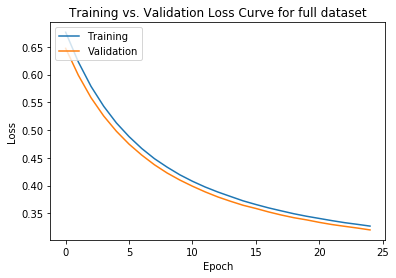

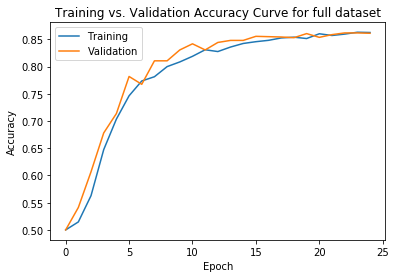

In [6]:
# ------------------------------ BASELINE (FULL DATASET) ------------------------------ 
def main():
    ######
    # Processing of the data
    # This code uses 3 files: train.tsv, validation.tsv and test.tsv
    # which all reside in a folder named "data".
    ######

    # Instantiates 2 data.Field objects 
    TEXT = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
    LABELS = data.Field(sequential=False, use_vocab=False)

    # Load the train, validation, and test datasets to become datasets
    train_data, val_data, test_data = data.TabularDataset.splits(
            path='data/', train='train.tsv',
            validation='validation.tsv', test='test.tsv', format='tsv',
            skip_header=True, fields=[('text', TEXT), ('label', LABELS)])

    # Create an object that can be enumerated (for training loop later)
    train_iter, val_iter, test_iter = data.BucketIterator.splits(
      (train_data, val_data, test_data), batch_sizes=(batch_size, batch_size, batch_size),
    sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)
    
    # Vocab object contains the index/token for each unique word in the dataset (looks through all sentences in dataset)
    TEXT.build_vocab(train_data, val_data, test_data)

    # Loading GloVe Vector and Using Embedding Layer
    TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=100))
    vocab = TEXT.vocab

    print("Shape of Vocab:",TEXT.vocab.vectors.shape) #number of unique words 
    
    # Training the baseline model --------------------
    # Reproducability 
    torch.manual_seed(seed)

    # Initiate model 
    model = Baseline(100,vocab) ### 
    
    # Define loss and optimzer functions 
    loss_fnc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)


    # Store for plotting
    loss_list = []
    acc_list = []
    nepoch = []

    val_acc_list = []
    val_loss_list = []

    # TRAINING LOOP --------------------
    for e in range(epochs): 
        nepoch = nepoch + [e]

        batchloss_accum = 0.0
        batchacc_accum = 0.0
        model.train() 

        # For batch in train_iter: #len train_iter is number of batches 
        for i, batch in enumerate(train_iter, 0):
            correct = 0 
            total = 0 
            
            # Zero parameter gradients
            optimizer.zero_grad()
            
            # Run model on inputs
            #print(batch.text)#(batch input = sentence, batch input length = 15s --> tuple of 2 tensors)
            batch_input, batch_input_length = batch.text

            outputs = model(batch_input)
            #print(outputs.shape)
            #print(batch.label.float().shape)
            
            # Compute loss
            batchloss = loss_fnc(outputs, batch.label.float()) #(batch.label) (tensor of 64 1s and 0s)
            batchloss_accum = batchloss_accum + batchloss.item() #added values of loss for all batches
            #print('batchloss',batchloss)
            
            batchloss.backward()
            optimizer.step()
            
            # Compute accuracy 
            batchacc = accuracy(outputs,batch.label.float())
            batchacc_accum = batchacc_accum + batchacc
            #print("Batch accuracy",batchacc)
            
            if i == len(train_iter)-1: #len(trainloader) is len(dataset)
                model.eval()
                vacc, vloss = evaluate(model,val_iter)
                
                
                print("avg acc/epoch", batchacc_accum/len(train_iter))
                print('[%d, %5d] avg loss/epoch: %.3f' % (e + 1, i + 1, batchloss_accum/len(train_iter)))
                print("validation loss:", vloss)
                print("validation acc:", vacc)

                loss_list = loss_list + [batchloss_accum/len(train_iter)]
                acc_list = acc_list + [batchacc_accum/len(train_iter)]
                val_acc_list.append(vacc)   
                val_loss_list.append(vloss)

                batchloss_accum = 0.0
                batchacc_accum = 0.0 
    
    # Evaluate with test dataset
    model.eval()
    tacc,tloss = evaluate(model,test_iter)
    print(tacc,tloss)

    print("Final Test Acccuracy:", tacc)
    
    # LOSS TOGETHER
    plt.plot(nepoch,loss_list, label = 'Train')
    plt.plot(nepoch,val_loss_list, label = 'Valid')
    plt.xlabel("Epoch")
    plt.ylabel("Loss") 
    plt.title("Training vs. Validation Loss Curve for full dataset")
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show() 

    # ACCURACIES TOGETHER
    plt.plot(nepoch,acc_list, label = 'Train')
    plt.plot(nepoch,val_acc_list, label = 'Validation')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy") 
    plt.title("Training vs. Validation Accuracy Curve for full dataset")
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show() 
    
    torch.save(model,'models/model_baseline.pt')


if __name__ == '__main__':
    main()



Shape of Vocab: torch.Size([21105, 100])
avg acc/epoch 0.7103125
[1,   100] avg loss/epoch: 0.638
validation loss: 0.5800852394104004
validation acc: 0.85
avg acc/epoch 0.8834375
[2,   100] avg loss/epoch: 0.569
validation loss: 0.5629928827285766
validation acc: 0.8775
avg acc/epoch 0.90390625
[3,   100] avg loss/epoch: 0.555
validation loss: 0.5567397511005402
validation acc: 0.901875
avg acc/epoch 0.9215625
[4,   100] avg loss/epoch: 0.547
validation loss: 0.5528816306591033
validation acc: 0.90875
avg acc/epoch 0.935
[5,   100] avg loss/epoch: 0.541
validation loss: 0.5503709578514099
validation acc: 0.91
avg acc/epoch 0.94078125
[6,   100] avg loss/epoch: 0.537
validation loss: 0.5519863152503968
validation acc: 0.889375
avg acc/epoch 0.9471875
[7,   100] avg loss/epoch: 0.533
validation loss: 0.5482652938365936
validation acc: 0.913125
avg acc/epoch 0.95546875
[8,   100] avg loss/epoch: 0.530
validation loss: 0.5475215291976929
validation acc: 0.9125
avg acc/epoch 0.9596875
[9,  

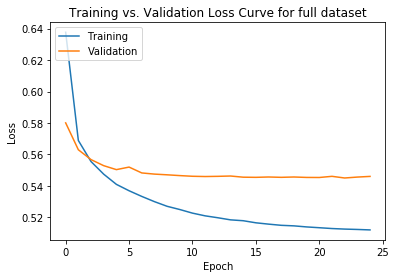

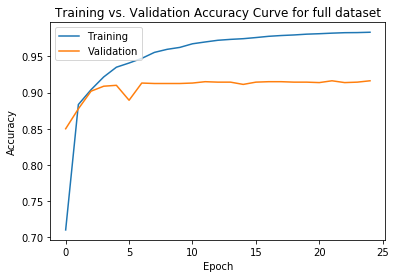

In [7]:
# ------------------------------ CNN (FULL DATASET) ------------------------------ 
def main():
    ######
    # Processing of the data
    # This code uses 3 files: train.tsv, validation.tsv and test.tsv
    # which all reside in a folder named "data".
    ######

    #Instantiates 2 data.Field objects 
    TEXT = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
    LABELS = data.Field(sequential=False, use_vocab=False)

    #Load the train, validation, and test datasets to become datasets
    train_data, val_data, test_data = data.TabularDataset.splits(
            path='data/', train='train.tsv',
            validation='validation.tsv', test='test.tsv', format='tsv',
            skip_header=True, fields=[('text', TEXT), ('label', LABELS)])

    # Create an object that can be enumerated (for training loop later)
    train_iter, val_iter, test_iter = data.BucketIterator.splits(
      (train_data, val_data, test_data), batch_sizes=(batch_size, batch_size, batch_size),
    sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)
    
    # Vocab object contains the index/token for each unique word in the dataset (looks through all sentences in dataset)
    TEXT.build_vocab(train_data, val_data, test_data)

    # Loading GloVe Vector and Using Embedding Layer
    TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=100))
    vocab = TEXT.vocab

    print("Shape of Vocab:",TEXT.vocab.vectors.shape) #number of unique words 
    
    # Training the CNN model--------------------
    # Reproducability 
    torch.manual_seed(seed)

    # Initiate model 
    model = CNN(100, vocab, 50, (2,4)) ###
    
    #Define loss and optimzer functions 
    loss_fnc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

  
    # Store for plotting
    loss_list = []
    acc_list = []
    nepoch = []

    val_acc_list = []
    val_loss_list = []

    # TRAINING LOOP --------------------
    for e in range(epochs): 
        nepoch = nepoch + [e]

        batchloss_accum = 0.0
        batchacc_accum = 0.0
        model.train() 

        # For batch in train_iter: #len train_iter is number of batches 
        for i, batch in enumerate(train_iter, 0):
            correct = 0 
            total = 0 
            
            # Zero parameter gradients
            optimizer.zero_grad()
            
            # Run model on inputs
            batch_input, batch_input_length = batch.text
            outputs = model(batch_input)
            #print(outputs.shape)
            #print(batch.label.float().shape)
            
            # Compute loss
            batchloss = loss_fnc(outputs, batch.label.float()) #(batch.label) (tensor of 64 1s and 0s)
            batchloss_accum = batchloss_accum + batchloss.item() #added values of loss for all batches
            #print('batchloss',batchloss)

            batchloss.backward()
            optimizer.step()
            
            # Compute accuracy 
            batchacc = accuracy(outputs,batch.label.float())
            batchacc_accum = batchacc_accum + batchacc
            #print("Batch accuracy",batchacc)
            
            if i == len(train_iter)-1: 
                model.eval()
                vacc, vloss = evaluate(model,val_iter)
                
                
                print("avg acc/epoch", batchacc_accum/len(train_iter))
                print('[%d, %5d] avg loss/epoch: %.3f' % (e + 1, i + 1, batchloss_accum/len(train_iter)))
                print("validation loss:", vloss)
                print("validation acc:", vacc)

                loss_list = loss_list + [batchloss_accum/len(train_iter)]
                acc_list = acc_list + [batchacc_accum/len(train_iter)]
                val_acc_list.append(vacc)   
                val_loss_list.append(vloss)

                batchloss_accum = 0.0
                batchacc_accum = 0.0 
    
    # Evaluate with test dataset
    model.eval()
    tacc,tloss = evaluate(model,test_iter)
    print(tacc,tloss)

    print("Final Test Acccuracy:", tacc)
    
    # LOSS TOGETHER
    plt.plot(nepoch,loss_list, label = 'Train')
    plt.plot(nepoch,val_loss_list, label = 'Valid')
    plt.xlabel("Epoch")
    plt.ylabel("Loss") 
    plt.title("Training vs. Validation Loss Curve for full dataset")
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show() 

    # ACCURACIES TOGETHER
    plt.plot(nepoch,acc_list, label = 'Train')
    plt.plot(nepoch,val_acc_list, label = 'Validation')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy") 
    plt.title("Training vs. Validation Accuracy Curve for full dataset")
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show() 

    # Save the model 
    torch.save(model,'models/model_cnn.pt')


if __name__ == '__main__':
    main()



Shape of Vocab: torch.Size([21105, 100])
avg acc/epoch 0.674375
[1,   100] avg loss/epoch: 0.636
validation loss: 0.5580377328395844
validation acc: 0.893125
avg acc/epoch 0.87984375
[2,   100] avg loss/epoch: 0.562
validation loss: 0.552857848405838
validation acc: 0.89
avg acc/epoch 0.8875
[3,   100] avg loss/epoch: 0.556
validation loss: 0.5495517349243164
validation acc: 0.89625
avg acc/epoch 0.901875
[4,   100] avg loss/epoch: 0.550
validation loss: 0.5476996564865112
validation acc: 0.91125
avg acc/epoch 0.90328125
[5,   100] avg loss/epoch: 0.549
validation loss: 0.5464955258369446
validation acc: 0.903125
avg acc/epoch 0.89515625
[6,   100] avg loss/epoch: 0.551
validation loss: 0.5486679422855377
validation acc: 0.89375
avg acc/epoch 0.91734375
[7,   100] avg loss/epoch: 0.542
validation loss: 0.5464931869506836
validation acc: 0.91
avg acc/epoch 0.9165625
[8,   100] avg loss/epoch: 0.542
validation loss: 0.5574679362773896
validation acc: 0.86625
avg acc/epoch 0.91609375
[9, 

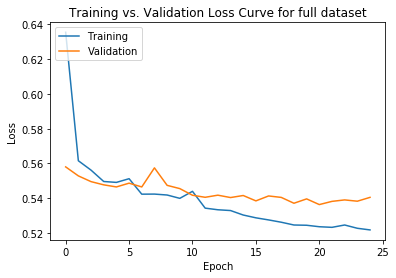

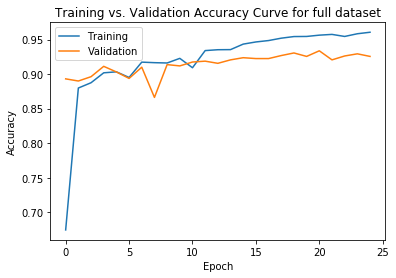

In [8]:
# ------------------------------ RNN (FULL DATASET) ------------------------------ 

# Modified evaluation function for the RNN (changed for model that takes in sentence length too)
def evaluateRNN(model, val_iter):
    loss_fnc = nn.BCEWithLogitsLoss()

    correct = 0 
    total = 0 
    
    batchloss_accum = 0.0
    batchacc_accum = 0.0
    
    for i,batch in enumerate(val_iter,0): #go through each batch in val_loader
        
        batch_input, batch_input_length = batch.text
        sentence_length = batch_input_length[0].item() # = len(batch_input)
        
        outputs = model(batch_input,batch_input_length) #batch_input has size [sentence length, batch size]
        
        #Calculate accuracy 
        acc = accuracy(outputs,batch.label.float())
        batchacc_accum = batchacc_accum + acc
        
        #Calculate loss
        batchloss = loss_fnc(outputs, batch.label.float()) #(batch.label) (tensor of 64 1s and 0s)
        batchloss_accum = batchloss_accum + batchloss.item()


    avgbatchloss = batchloss_accum/len(val_iter)
    avgbatchacc = batchacc_accum/len(val_iter)
    
    return avgbatchacc, avgbatchloss

def main():
    ######
    # Processing of the data
    # This code uses 3 files: train.tsv, validation.tsv and test.tsv
    # which all reside in a folder named "data".
    ######

    # Instantiates 2 data.Field objects 
    TEXT = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
    LABELS = data.Field(sequential=False, use_vocab=False)

    # Load the train, validation, and test datasets to become datasets
    train_data, val_data, test_data = data.TabularDataset.splits(
            path='data/', train='train.tsv',
            validation='validation.tsv', test='test.tsv', format='tsv',
            skip_header=True, fields=[('text', TEXT), ('label', LABELS)])

    # Create an object that can be enumerated (for training loop later)
    train_iter, val_iter, test_iter = data.BucketIterator.splits(
      (train_data, val_data, test_data), batch_sizes=(batch_size, batch_size, batch_size),
    sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)
    
    # bucketiterator/iterator changed for testing here 
    
    # Vocab object contains the index/token for each unique word in the dataset (looks through all sentences in dataset)
    TEXT.build_vocab(train_data, val_data, test_data)

    # Loading GloVe Vector and Using Embedding Layer
    TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=100))
    vocab = TEXT.vocab

    print("Shape of Vocab:",TEXT.vocab.vectors.shape) #number of unique words 
    
    # Training the RNN model --------------------
    # Reproducability 
    torch.manual_seed(seed)

    # Initiate model 
    model = RNN(100,vocab,100) ###
    
    # Define loss and optimzer functions 
    loss_fnc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)


    # Store for plotting
    loss_list = []
    acc_list = []
    nepoch = []

    val_acc_list = []
    val_loss_list = []

    # TRAINING LOOP --------------------
    for e in range(epochs): 
        nepoch = nepoch + [e]

        batchloss_accum = 0.0
        batchacc_accum = 0.0
        model.train() 

        # For batch in train_iter: #len train_iter is number of batches 
        for i, batch in enumerate(train_iter, 0):
            correct = 0 
            total = 0 
            
            # Zero parameter gradients
            optimizer.zero_grad()
            
            # Run model on inputs
            #print(batch.text)#(batch input = sentence, batch input length = 15s --> tuple of 2 tensors)
            batch_input, batch_input_length = batch.text
            sentence_length = batch_input_length[0].item()

            outputs = model(batch_input,batch_input_length) #batch_input has size [sentence length, batch size]
            #print(outputs.shape)
            #print(batch.label.float().shape)
            
            # Compute loss
            batchloss = loss_fnc(outputs, batch.label.float()) #(batch.label) (tensor of 64 1s and 0s)
            batchloss_accum = batchloss_accum + batchloss.item() #added values of loss for all batches
            #print('batchloss',batchloss)
            
            batchloss.backward()
            optimizer.step()

            # Compute accuracy 
            batchacc = accuracy(outputs,batch.label.float())
            batchacc_accum = batchacc_accum + batchacc
            
            #print("Batch accuracy",batchacc)
            
            if i == len(train_iter)-1: 
                model.eval()
                vacc, vloss = evaluateRNN(model,val_iter)
                
                
                print("avg acc/epoch", batchacc_accum/len(train_iter))
                print('[%d, %5d] avg loss/epoch: %.3f' % (e + 1, i + 1, batchloss_accum/len(train_iter)))
                print("validation loss:", vloss)
                print("validation acc:", vacc)

                loss_list = loss_list + [batchloss_accum/len(train_iter)]
                acc_list = acc_list + [batchacc_accum/len(train_iter)]
                val_acc_list.append(vacc)   
                val_loss_list.append(vloss)

                batchloss_accum = 0.0
                batchacc_accum = 0.0 
    
    # Evaluate with test dataset
    model.eval()
    tacc,tloss = evaluateRNN(model,test_iter)
    print(tacc,tloss)

    print("Final Test Acccuracy:", tacc)
    
    # LOSS TOGETHER
    plt.plot(nepoch,loss_list, label = 'Train')
    plt.plot(nepoch,val_loss_list, label = 'Valid')
    plt.xlabel("Epoch")
    plt.ylabel("Loss") 
    plt.title("Training vs. Validation Loss Curve for full dataset")
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show() 

    # ACCURACIES TOGETHER
    plt.plot(nepoch,acc_list, label = 'Train')
    plt.plot(nepoch,val_acc_list, label = 'Validation')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy") 
    plt.title("Training vs. Validation Accuracy Curve for full dataset")
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show() 
    
    # Save the model 
    torch.save(model,'models/model_rnn.pt')


if __name__ == '__main__':
    main()